In [1]:
import utils 
import os, sys, shutil, random
import numpy as np
from IPython.display import display, Image
from IPython import display
import yaml
import glob
import cv2
display.clear_output()
!yolo checks
HOME = os.getcwd()

Ultralytics YOLOv8.2.42 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
Setup complete ✅ (72 CPUs, 250.5 GB RAM, 354.2/1876.2 GB disk)

OS                  Linux-5.15.0-107-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             pip
RAM                 250.54 GB
CPU                 Intel Xeon Gold 5220 2.20GHz
CUDA                12.1

numpy               ✅ 1.24.4<2.0.0,>=1.23.5
matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.2.1>=1.8.0
torchvision         ✅ 0.17.1>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.8
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


In [2]:
def create_dir_structure(base_dir:str) ->None:
    """Create the directory structure for train and validation sets.
    Args:
        base_dir: Directory we want to host the train and validation sets.

    Return: None, but create folders to build desired structure


    """
    dirs = [
        os.path.join(base_dir, 'train_images'),
        os.path.join(base_dir, 'train_masks', 'Blebs'),
        os.path.join(base_dir, 'train_masks', 'Compact'),
        os.path.join(base_dir, 'train_masks', 'Destructured'),
        os.path.join(base_dir, 'val_images'),
        os.path.join(base_dir, 'val_masks', 'Blebs'),
        os.path.join(base_dir, 'val_masks', 'Compact'),
        os.path.join(base_dir, 'val_masks', 'Destructured'),
    ]
    for dir in dirs:
        os.makedirs(dir, exist_ok=True)


In [3]:
def split_data(input_dir:str, output_dir:str, val_ratio=0.2) -> None:
    create_dir_structure(output_dir)
    
    train_images_dir = os.path.join(input_dir, 'images')
    print(f"train_images_dir: {train_images_dir}")
    train_masks_dir = os.path.join(input_dir, 'masks')
    print(f"train_masks_dir: {train_masks_dir}")
    
    categories = ['Blebs', 'Compact', 'Destructured']
    
    for category in categories:
        mask_category_dir = os.path.join(train_masks_dir, category)
        print(f"Processing category: {category}")
        
       
        image_files = sorted(os.listdir(train_images_dir))
        image_files = [f for f in image_files if f.lower().endswith(('tif'))]  # Make the extension check case-insensitive
        
        num_images = len(image_files)
        num_val = int(num_images * val_ratio)
        
        val_images = random.sample(image_files, num_val)
        train_images = [img for img in image_files if img not in val_images]
        
        for img in train_images:
            img_name = os.path.basename(img)
            src_mask_path = os.path.join(mask_category_dir, img)
            dst_mask_path = os.path.join(output_dir, 'train_masks', category, img)
            
            shutil.copy(src_mask_path, dst_mask_path)
        
        for img in val_images:
            img_name = os.path.basename(img)
            src_mask_path = os.path.join(mask_category_dir, img)
            dst_mask_path = os.path.join(output_dir, 'val_masks', category, img)

            shutil.copy(src_mask_path, dst_mask_path)

    print(f"Category {category} - Train: {len(train_images)}, Val: {len(val_images)}")

    for img in train_images:
        img_name = os.path.basename(img)
        src_img_path = os.path.join(train_images_dir, img_name)
        dst_img_path = os.path.join(output_dir, 'train_images', img_name)
        shutil.copy(src_img_path, dst_img_path)

    for img in val_images:
            img_name = os.path.basename(img)
            src_img_path = os.path.join(train_images_dir, img_name)   
            dst_img_path = os.path.join(output_dir, 'val_images', img_name)
            shutil.copy(src_img_path, dst_img_path)

        


        

In [4]:
input_directory = "train"
output_directory = HOME + "/input"
split_data(input_directory, output_directory)

train_images_dir: train/images
train_masks_dir: train/masks
Processing category: Blebs
Processing category: Compact
Processing category: Destructured
Category Destructured - Train: 214, Val: 53


In [5]:
import os
import glob
import cv2
import json
import numpy as np
import shutil
import utils


def process_masks(mask_paths: str, output_dir: str, **kwargs: dict) -> None:
    category_ids = {
        "Blebs": 1,
        "Compact": 2,
        "Destructured": 3
    }

    annotations = []
    images = []
    image_id = 0
    ann_id = 0
    MASKS_EXT = 'tif'
    ORIGINAL_EXT = 'tif'

    for category in category_ids.keys():
        for mask_image in glob.glob(os.path.join(mask_paths, category, f'*.{MASKS_EXT}')):
            img_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
            mask = cv2.imread(mask_image, cv2.IMREAD_UNCHANGED)
            
            if mask is None:
                print(f"Warning: Mask image {mask_image} could not be read.")
                continue
            
            # Get image dimensions
            height, width = mask.shape[:2]

            # Create or find existing image annotation
            if img_file_name not in map(lambda img: img['file_name'], images):
                image_id += 1
                images.append({
                    "id": image_id,
                    "file_name": img_file_name,
                    "height": height,
                    "width": width
                })
                image = images[-1]  # The newly added image
            else:
                image = [element for element in images if element['file_name'] == img_file_name][0]

            unique_values = np.unique(mask)
            for value in unique_values:
                if value == 0:
                    continue

                object_mask = (mask == value).astype(np.uint8) * 255
                polygons = utils.mask_to_polygons(object_mask)

                for poly in polygons:
                    ann_id += 1
                    annotations.append({
                        "id": ann_id,
                        "image_id": image['id'],
                        "category_id": category_ids[category],
                        "segmentation": [poly],
                        "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                        "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                        "iscrowd": 0
                    })

    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()]
    }

    with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
        json.dump(coco_output, f)

    print("Created %d annotations for images in folder: %s" % (len(annotations), mask_paths))


In [ ]:
HOME

In [ ]:
import os

def delete_files_with_extension(directory_path, extension):
    for filename in os.listdir(directory_path):
        if filename.endswith(extension):
            file_path = os.path.join(directory_path, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

# Exemple d'utilisation
directory_path = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/train/images"
extension = ".npy"  # Remplacez par l'extension que vous souhaitez supprimer
delete_files_with_extension(directory_path, extension)


In [6]:
HOME
train_masks_path= HOME +  "/input/train_masks"
train_output_dir =HOME + "/input/train_images"
process_masks(mask_paths=train_masks_path, output_dir=train_output_dir)

Created 9968 annotations for images in folder: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/input/train_masks


In [7]:
val_masks_path= HOME+  "/input/val_masks"
val_output_dir =HOME + "/input/val_images"
process_masks(mask_paths=val_masks_path, output_dir=val_output_dir)

Created 2042 annotations for images in folder: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/input/val_masks


In [8]:
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".tif"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        if img is None:
            print(f"Warning: No annotation found for image {filename}")
            continue  # Skip this image if no annotation is found
        
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")


# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    
    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


In [9]:
base_input_path = "input/"
base_output_path = "yolo_dataset/"

In [10]:
# Processing training dataset 
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "train_images"),
    input_json_path=os.path.join(base_input_path, "train_images/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels")
)

In [19]:
# Processing validation dataset (if needed)
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "val_images"),
    input_json_path=os.path.join(base_input_path, "val_images/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

In [11]:
# Creating the YAML configuration file
create_yaml(
    input_json_path=os.path.join(base_input_path, "train_images/coco_annotations.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path="train/images",
    val_path="valid/images",
    test_path='../test/images'  # or None if not applicable
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".tif", ".txt")) for f in random_image_files]

In [ ]:
display_images_with_annotations(image_paths, annotation_paths)


In [ ]:
#!pip install -U scikit-image

In [ ]:
import os

def remove_spaces_in_filenames(directory):
    for filename in os.listdir(directory):
        # Vérifiez si le fichier a des espaces dans son nom
        if ' ' in filename:
            # Nouveau nom du fichier sans espaces
            new_filename = filename.replace(' ', '')
            # Chemins complets pour l'ancien et le nouveau nom du fichier
            old_filepath = os.path.join(directory, filename)
            new_filepath = os.path.join(directory, new_filename)
            # Renommer le fichier
            os.rename(old_filepath, new_filepath)
            print(f"Renommé : {old_filepath} -> {new_filepath}")



In [ ]:
import os

def rename_files_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        new_filename = filename.replace('(', '_').replace(')', '_')
        old_file_path = os.path.join(directory_path, filename)
        new_file_path = os.path.join(directory_path, new_filename)
        
        if old_file_path != new_file_path:
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {old_file_path} to {new_file_path}")



In [ ]:
# Exemple d'utilisation
directory_path = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/train/masks/Destructured"
#rename_files_in_directory(directory_path)

In [ ]:
# Exemple d'utilisation
directory_path = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/train/masks/Destructured"
#remove_spaces_in_filenames(directory_path)

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".tif", ".txt")) for f in random_image_files]


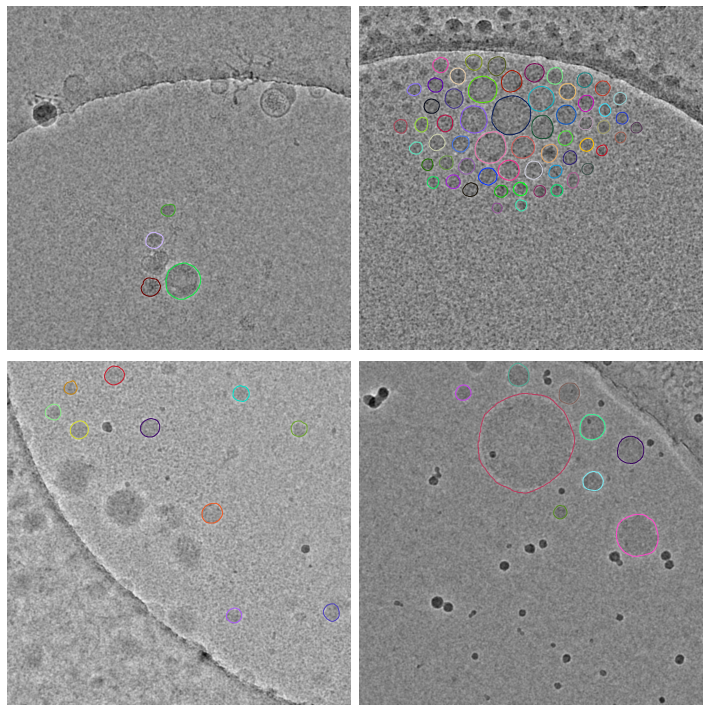

In [12]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV
        image = cv2.imread(img_path)

        # Vérifiez si l'image a été lue correctement
        if image is None:
            print(f"Erreur de lecture de l'image : {img_path}")
            continue

        # Convert it from BGR to RGB color space
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".tif", ".txt")) for f in random_image_files]

# Display images with annotations
display_images_with_annotations(image_paths, annotation_paths)


In [ ]:
print(image_paths)
print(annotation_paths)

In [ ]:
display_images_with_annotations(image_paths, annotation_paths)

In [3]:
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.2.42 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
Setup complete ✅ (72 CPUs, 250.5 GB RAM, 354.2/1876.2 GB disk)

OS                  Linux-5.15.0-107-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             pip
RAM                 250.54 GB
CPU                 Intel Xeon Gold 5220 2.20GHz
CUDA                12.1

numpy               ✅ 1.24.4<2.0.0,>=1.23.5
matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.2.1>=1.8.0
torchvision         ✅ 0.17.1>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.8
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


In [4]:
model = YOLO("yolov8m-seg.yaml") # build a new model from yaml
model = YOLO("yolo_dataset/results/125_epochs_seg_m_tune/weights/best.pt") # transfer weights fro a pre-trained model (recommended for training)

In [5]:
with open('yolo_dataset/data.yaml', 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
sanofi_projct = "yolo_dataset/results"
name = "125_epochs_seg_m_tune_best"

In [7]:
# Train the model
results = model.train(data=HOME + '/yolo_dataset/data.yaml',
                    project=sanofi_projct,
                    name=name,
                    epochs=125,
                    lr0=0.01,
                    lrf=0.01,
                    momentum=0.937,
                    weight_decay=0.0005,
                    label_smoothing=0.0,
                    hsv_h=0.015,
                    hsv_s=0.7,
                    hsv_v=0.4,
                    degrees=0.0,
                    translate=0.1,
                    scale=0.5,
                    shear=0.0,
                    flipud=0.0,
                    fliplr=0.5,
                    mosaic=1.0,
                    mixup=0.0
                    )
     

New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.42 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
engine/trainer: task=segment, mode=train, model=yolo_dataset/results/125_epochs_seg_m_tune/weights/best.pt, data=/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/yolo_dataset/data.yaml, epochs=125, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_dataset/results, name=125_epochs_seg_m_tune_best, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True,

2024-07-04 13:42:25,205	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-04 13:42:25,488	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

train: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/yolo_dataset/train/labels.cache... 183 images, 31 backgrounds, 0 corrupt: 100%|██████████| 214/214 [00:00<?, ?it/s]
val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/yolo_dataset/valid/labels.cache... 20 images, 33 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]


Plotting labels to yolo_dataset/results/125_epochs_seg_m_tune_best/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_dataset/results/125_epochs_seg_m_tune_best
Starting training for 125 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/125      11.6G      0.833      1.109     0.5525     0.8665        675        640: 100%|██████████| 14/14 [00:16<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         53        419      0.308      0.849      0.385      0.319      0.308      0.849      0.385      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/125      10.4G     0.8369      1.067     0.5785     0.8702        263        640: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         53        419      0.534      0.668      0.556      0.475      0.534      0.668      0.556        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/125        11G     0.8333      1.158     0.5632     0.8886        213        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         53        419      0.493       0.75       0.52       0.45      0.493      0.749       0.52      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/125      11.3G     0.8941      1.167     0.6266     0.8793        439        640: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         53        419      0.644      0.388      0.292      0.231      0.644      0.388      0.291      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/125      11.7G      0.889      1.159     0.5828     0.8872        666        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         53        419      0.187      0.445      0.208      0.166      0.187      0.445      0.207      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/125      10.7G     0.8659      1.107      0.575     0.8825        239        640: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         53        419      0.338      0.681      0.314      0.247      0.338       0.68      0.313       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/125      11.9G      0.858      1.175     0.6317     0.8925         78        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         53        419      0.304      0.653      0.408      0.314      0.304      0.653      0.408       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/125      11.9G     0.8688      1.106     0.5838     0.8796        159        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         53        419      0.636      0.405      0.467      0.398      0.636      0.405      0.467      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/125      12.7G     0.8511      1.106     0.5669     0.8796        276        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         53        419      0.428      0.493      0.539      0.424      0.428      0.493      0.539      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/125      11.2G     0.8681      1.102     0.6395     0.8765        136        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         53        419      0.186      0.382      0.165      0.127      0.186      0.381      0.165       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/125      11.3G      0.864      1.131     0.6881     0.8951        126        640: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         53        419      0.186      0.377      0.188      0.143      0.186      0.377      0.188      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/125      12.7G     0.8557      1.196     0.6074     0.8809        178        640: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         53        419      0.305      0.775      0.423      0.355      0.305      0.774      0.423      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/125      11.4G       0.87      1.196     0.6268     0.8868        479        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         53        419      0.543      0.569      0.547      0.437      0.543      0.569      0.547       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/125      12.6G     0.8431      1.084     0.5841     0.8815        197        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         53        419     0.0969      0.757       0.12     0.0922     0.0966      0.756       0.12     0.0874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/125      10.4G     0.8658      1.175     0.6198      0.889        293        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         53        419      0.542      0.571      0.566       0.45      0.542      0.571      0.566      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/125      11.8G     0.8604      1.158     0.5865     0.8867        572        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         53        419      0.269      0.781      0.354      0.278      0.269      0.781      0.354      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/125      11.9G     0.8635      1.139     0.6317      0.877        502        640: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         53        419       0.17      0.646      0.216      0.152       0.17      0.646      0.216      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/125      11.6G     0.8742      1.158     0.6072     0.8751        291        640: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         53        419      0.195      0.627      0.244      0.188      0.195      0.626      0.243      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/125      11.6G     0.8487      1.117     0.6145     0.8702        447        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         53        419       0.14      0.651      0.143      0.111       0.14      0.651      0.143      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/125      11.7G     0.8818      1.202     0.6275      0.893        420        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         53        419      0.446      0.615      0.504      0.399      0.446      0.615      0.504      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/125      11.2G     0.8783      1.189     0.5956     0.8913        488        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         53        419      0.475      0.379      0.502      0.398      0.475      0.379      0.502      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/125      11.6G     0.8574       1.09     0.6189     0.8738        543        640: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         53        419      0.693       0.59      0.535      0.421      0.693       0.59      0.535      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/125      11.8G     0.8396      1.104     0.6377      0.881        148        640: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         53        419       0.48      0.609      0.474      0.378       0.48      0.609      0.474      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/125      11.8G     0.8444      1.123       0.61     0.8691        296        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         53        419      0.304      0.737      0.276      0.211      0.304      0.737      0.276      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/125      11.5G     0.8577      1.161     0.6018      0.882        188        640: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         53        419      0.708      0.514       0.56      0.477      0.708      0.514       0.56        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/125      11.3G     0.8455      1.147     0.6025     0.8902        183        640: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         53        419      0.441      0.527      0.532      0.451      0.441      0.527      0.532      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/125      11.4G     0.8513      1.106     0.5649     0.8874        400        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         53        419      0.332      0.707      0.368      0.276      0.332      0.707      0.368      0.266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/125      12.2G      0.857      1.126     0.5639     0.8868        321        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         53        419      0.592      0.689       0.58      0.454      0.592      0.689       0.58      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/125      11.8G     0.8395      1.112     0.6098     0.8711        166        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         53        419      0.387      0.601      0.408      0.311      0.387      0.601      0.408      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/125        12G     0.8419      1.096      0.571       0.87        343        640: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         53        419      0.352      0.666       0.46      0.356      0.352      0.666       0.46      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/125      10.9G     0.8578      1.188     0.5761     0.8785        331        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         53        419      0.461      0.475      0.521      0.411      0.461      0.475      0.521      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/125      10.9G     0.8344      1.082     0.5777     0.8839         74        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         53        419      0.298      0.731      0.387      0.306      0.298      0.731      0.387      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/125      11.3G      0.832      1.083     0.5332     0.8667        278        640: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         53        419       0.63      0.589      0.577      0.485       0.63      0.589      0.577      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/125        11G     0.8472      1.115     0.5396     0.8767        525        640: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         53        419      0.362      0.714       0.56      0.434      0.362      0.714       0.56      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/125      10.3G     0.8438      1.097     0.5348     0.8791        363        640: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         53        419      0.299      0.821      0.338      0.253      0.299       0.82      0.338      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/125      11.4G     0.8556      1.128     0.5391     0.8761        162        640: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         53        419      0.468      0.764      0.569      0.448      0.468      0.763      0.568      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/125      11.3G     0.8209      1.054     0.5346     0.8713        422        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         53        419      0.496      0.688      0.618      0.486      0.496      0.688      0.618      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/125      11.5G     0.8516      1.136     0.6185      0.874        800        640: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         53        419      0.441      0.546      0.403      0.317      0.441      0.546      0.403       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/125      11.3G     0.8572      1.125     0.6008     0.8736        563        640: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         53        419      0.449      0.538      0.383      0.295      0.449      0.538      0.383      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/125      11.6G     0.8262      1.073     0.5219     0.8756        239        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         53        419      0.289      0.805      0.289       0.24      0.289      0.805      0.289      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/125      11.3G     0.8435      1.114     0.5581     0.8723        474        640: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         53        419      0.253      0.777      0.261      0.211      0.253      0.777      0.261      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/125      10.2G     0.8362      1.147     0.5495     0.8864        270        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         53        419      0.576      0.515      0.537      0.462      0.576      0.515      0.537      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/125      10.5G     0.8459      1.118     0.5732     0.8881        118        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         53        419      0.427      0.645      0.363      0.296      0.427      0.645      0.363       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/125      10.7G     0.8463      1.088     0.5289     0.8784        134        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         53        419      0.558      0.583      0.326      0.274      0.558      0.583      0.326      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/125      11.2G     0.8362      1.095      0.551     0.8752        381        640: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         53        419      0.454      0.513       0.56      0.473      0.454      0.513      0.559      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/125      11.2G      0.829      1.087     0.5161     0.8656        392        640: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         53        419      0.356      0.739      0.373      0.305      0.356      0.739      0.374      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/125      12.2G     0.8226      1.061     0.5084     0.8751        102        640: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         53        419      0.297      0.701      0.311      0.244      0.297        0.7      0.311       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/125      11.2G      0.807      1.063      0.496     0.8703        236        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         53        419      0.311      0.791      0.358       0.23      0.311      0.791      0.358      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/125      11.2G     0.8215      1.037     0.5178      0.865        320        640: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         53        419      0.409       0.76      0.387      0.243      0.409       0.76      0.387      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/125       9.9G     0.8122       1.16     0.5393     0.8773        391        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         53        419       0.25      0.402      0.329      0.257       0.25      0.402      0.329      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/125      11.5G     0.8144      1.046     0.5085     0.8802        100        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         53        419      0.273      0.706      0.323       0.23      0.273      0.706      0.323       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/125      12.5G     0.8329      1.098     0.4959     0.8738        436        640: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         53        419      0.603      0.361      0.243      0.176      0.603      0.361      0.243      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/125      10.9G     0.8299      1.121     0.5156     0.8818        316        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         53        419      0.292      0.425      0.282      0.211      0.292      0.424      0.282      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/125      11.2G     0.8293      1.083     0.5261     0.8764        293        640: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         53        419      0.203      0.756      0.225      0.169      0.203      0.756      0.225      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/125      11.6G     0.8262      1.077     0.5166     0.8715        348        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         53        419      0.369        0.5      0.504      0.296      0.368      0.499      0.503      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/125      10.4G     0.8405      1.111     0.5086     0.8786        215        640: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         53        419      0.329       0.64      0.597      0.433      0.329       0.64      0.596      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/125      9.99G     0.8127      1.082     0.5054      0.879        343        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         53        419      0.384      0.453      0.551      0.432      0.384      0.453      0.551      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/125      9.94G      0.838      1.117     0.5987     0.8747        250        640: 100%|██████████| 14/14 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         53        419      0.117      0.732      0.163      0.129      0.117      0.732      0.162      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/125      11.6G      0.837      1.171      0.542     0.8668        414        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         53        419      0.337      0.582       0.33      0.279      0.337      0.582       0.33      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/125      10.2G     0.8206      1.071     0.5069      0.861        357        640: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         53        419      0.483      0.609      0.578      0.483      0.483      0.609      0.578      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/125      11.2G     0.8382      1.096     0.5213     0.8769        282        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         53        419      0.395      0.633      0.559      0.471      0.395      0.632      0.558      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/125      11.9G     0.8393      1.075     0.5326     0.8772        240        640: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         53        419      0.287      0.703      0.283       0.22      0.286      0.702      0.282      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/125      11.9G      0.819      1.081     0.5111     0.8726        217        640: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         53        419      0.262       0.86       0.27      0.215      0.262       0.86       0.27      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/125      11.1G     0.8185      1.097     0.5006     0.8787        355        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         53        419      0.421      0.679      0.397      0.297      0.421      0.679      0.396      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/125      12.6G      0.837      1.089     0.5079     0.8732        325        640: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         53        419      0.536      0.455      0.529      0.381      0.536      0.455      0.529      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/125      11.2G     0.8111      1.066     0.5121     0.8679        266        640: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         53        419      0.334      0.462      0.534      0.378      0.334      0.462      0.534      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/125      11.4G     0.8079      1.096     0.4727     0.8651        509        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         53        419       0.29       0.65      0.388      0.289       0.29       0.65      0.388      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/125      11.6G     0.8009      1.041     0.4707     0.8651        314        640: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         53        419      0.104      0.623      0.135      0.103      0.104      0.623      0.135      0.096



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/125      12.2G     0.8112      1.101     0.5056     0.8767        589        640: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         53        419      0.084      0.551     0.0928     0.0718      0.084      0.551     0.0927     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/125        12G     0.8079      1.096     0.4956      0.871        199        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         53        419        0.3      0.645      0.276      0.206        0.3      0.645      0.276      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/125      10.6G     0.7997      1.136     0.4693     0.8769        185        640: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         53        419      0.564      0.403      0.236      0.176      0.564      0.403      0.235      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/125      11.6G     0.8125      1.063     0.4578     0.8711        238        640: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         53        419      0.149      0.812      0.198      0.153      0.149      0.812      0.198      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/125      10.3G     0.8219      1.064     0.5266     0.8812         77        640: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         53        419      0.151      0.669      0.155      0.121      0.151      0.669      0.155      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/125      11.3G      0.804      1.053     0.4584     0.8713        228        640: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         53        419      0.175      0.811      0.195      0.153      0.175      0.811      0.195      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/125      10.6G      0.803      1.076     0.4977     0.8717        143        640: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         53        419      0.237      0.759       0.26      0.194      0.237      0.759       0.26      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/125      10.4G      0.787      1.058     0.4692     0.8679        262        640: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         53        419      0.312      0.655      0.347      0.251      0.312      0.655      0.347      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/125      11.3G     0.8129      1.101     0.4783     0.8727        278        640: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         53        419      0.463      0.554      0.364      0.274      0.463      0.554      0.364      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/125      11.2G     0.8132      1.069     0.4848     0.8707        157        640: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         53        419      0.188      0.343      0.196      0.153      0.188      0.342      0.196      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/125      11.9G     0.7961      1.024     0.4721     0.8737        106        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         53        419      0.284      0.501      0.288      0.218      0.284      0.501      0.288      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/125      11.4G     0.8023      1.039     0.4609     0.8669        707        640: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         53        419       0.29      0.836      0.282       0.22       0.29      0.836      0.282      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/125      11.5G     0.7924      1.049      0.451     0.8542        530        640: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         53        419      0.303      0.731      0.249      0.198      0.303      0.731      0.249      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/125      10.9G     0.7948      1.017      0.454     0.8709        145        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         53        419      0.252      0.387      0.299      0.222      0.252      0.387      0.299      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/125      10.3G     0.7751      1.032     0.4375     0.8616        198        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         53        419      0.553      0.725      0.618      0.426      0.553      0.725      0.618      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/125      11.1G     0.7956      1.024     0.4718     0.8608        141        640: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         53        419      0.549      0.511      0.618      0.486      0.549      0.511      0.618       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/125      11.4G     0.7826       1.03     0.4329     0.8625        362        640: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         53        419      0.541       0.46      0.606      0.479      0.541       0.46      0.606      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/125      11.8G     0.7733      1.003     0.4506     0.8675        570        640: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         53        419       0.43      0.705      0.617      0.455       0.43      0.705      0.617      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/125      10.6G     0.7751      1.017     0.4446     0.8677        227        640: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         53        419      0.253      0.739      0.311      0.232      0.253      0.739      0.311      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/125      11.6G     0.7832      1.044     0.4373     0.8638        304        640: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         53        419      0.186      0.301      0.199      0.157      0.186      0.301      0.199       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/125      10.3G     0.7644      1.019     0.4422     0.8607        115        640: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         53        419      0.155      0.397      0.189      0.149      0.155      0.396      0.189      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/125      11.6G     0.7842      1.022     0.4376     0.8634        368        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         53        419      0.278      0.464      0.264      0.201      0.278      0.464      0.264      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/125      11.2G     0.7738      1.005     0.4371     0.8592        265        640: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         53        419      0.382      0.754      0.415      0.314      0.382      0.754      0.415       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/125      11.8G     0.7892       1.03     0.4391     0.8607        633        640: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         53        419      0.364      0.693      0.354      0.274      0.363      0.692      0.354      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/125      10.8G     0.7823      1.042     0.4311     0.8648        216        640: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         53        419      0.399      0.659      0.396      0.322      0.399      0.659      0.396      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/125      9.73G     0.7655      1.009     0.4281     0.8565        460        640: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         53        419      0.191      0.829      0.244      0.193      0.191      0.829      0.244      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/125      11.2G     0.7807      1.032     0.4342     0.8588        239        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         53        419      0.256      0.433      0.271      0.215      0.256      0.433      0.271      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/125      12.3G     0.7793       1.03     0.4164     0.8552        263        640: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         53        419      0.269      0.877      0.307      0.244      0.269      0.876      0.307      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/125      11.8G     0.7705      1.026     0.4123     0.8507        536        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         53        419      0.345      0.793      0.363      0.289      0.345      0.793      0.363       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/125      13.3G     0.7618     0.9802     0.4083     0.8504        512        640: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         53        419      0.281       0.79      0.324      0.259      0.281       0.79      0.324      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/125      11.6G     0.7654      1.025     0.4027     0.8534        413        640: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         53        419      0.274       0.75      0.282      0.224      0.274       0.75      0.281      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/125      11.7G     0.7607      1.003     0.4202     0.8544        359        640: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         53        419      0.236      0.761      0.253      0.204      0.236      0.761      0.253      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/125      10.9G     0.7593      1.027     0.4205     0.8572        220        640: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         53        419      0.255      0.807      0.299      0.241      0.255      0.807      0.299      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/125      11.3G     0.7666     0.9752     0.4125     0.8613        198        640: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         53        419      0.267      0.871      0.321      0.256      0.267      0.871      0.321      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/125        12G     0.7642      0.993     0.4395      0.853        571        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         53        419      0.257      0.798      0.304      0.243      0.257      0.798      0.304      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/125      10.3G      0.763      1.016     0.4293     0.8636        368        640: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         53        419      0.271      0.379      0.278      0.218      0.271      0.378      0.278      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/125      10.2G     0.7446     0.9324      0.405      0.855        240        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         53        419      0.262      0.411      0.276      0.216      0.262       0.41      0.276      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/125      10.4G     0.7429     0.9446     0.3996     0.8585        279        640: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         53        419      0.349      0.664      0.358      0.275      0.349      0.663      0.357      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/125      10.8G     0.7481     0.9652     0.4046     0.8587        342        640: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         53        419      0.405      0.625      0.421      0.336      0.405      0.624       0.42      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/125      12.2G     0.7466     0.9757     0.3905     0.8544        341        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         53        419      0.348      0.771      0.374      0.298      0.348       0.77      0.374      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/125      11.5G     0.7612      1.084     0.4118      0.866        317        640: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         53        419      0.376      0.757      0.429      0.322      0.376      0.756      0.429      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/125      10.2G      0.769       1.06     0.4173     0.8689        189        640: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         53        419      0.462       0.69      0.577      0.457      0.462      0.689      0.576      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/125      12.9G     0.7469     0.9974     0.3946     0.8465        419        640: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         53        419      0.344      0.707      0.363      0.277      0.344      0.707      0.363      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/125        11G     0.7388     0.9796     0.3866      0.856        237        640: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         53        419      0.284      0.769      0.289      0.222      0.283      0.769      0.289      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/125      13.3G     0.7571     0.9994     0.4061     0.8523        301        640: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         53        419      0.279      0.777      0.303      0.242      0.279      0.776      0.303      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/125      12.4G      0.746      1.033     0.4057      0.861        216        640: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         53        419      0.262      0.776      0.297      0.236      0.262      0.775      0.296      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/125      12.2G     0.7447     0.9597      0.382     0.8504        350        640: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         53        419      0.303      0.735      0.311      0.236      0.303      0.734       0.31      0.225


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/125      12.2G     0.7634     0.9998     0.5794     0.8639         31        640: 100%|██████████| 14/14 [00:14<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         53        419      0.324      0.749      0.309      0.233      0.323      0.749      0.309      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/125      9.73G     0.7453      1.048     0.4342     0.8691         43        640: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         53        419      0.327      0.686      0.349      0.265      0.327      0.685      0.349      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/125      10.4G     0.7338       1.01     0.3769     0.8714        205        640: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         53        419      0.415      0.676      0.424      0.321      0.414      0.675      0.424      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/125      10.3G     0.7497      1.047     0.4046     0.8715        208        640: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         53        419      0.353      0.701      0.343      0.257      0.353        0.7      0.343      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/125      10.6G     0.7334      1.009     0.4346     0.8606        156        640: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         53        419      0.333      0.729      0.349      0.269      0.332      0.728      0.349      0.248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/125      10.5G     0.7289      1.033     0.3646     0.8634        194        640: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         53        419      0.333      0.738      0.348      0.263      0.333      0.737      0.348      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/125      11.2G     0.7145     0.9568     0.3512     0.8614        256        640: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         53        419      0.376      0.705       0.37      0.293      0.376      0.705       0.37      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/125      12.3G     0.7199     0.9544     0.3703     0.8577        147        640: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         53        419      0.384      0.706      0.418      0.332      0.384      0.705      0.418      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/125      11.6G     0.7161      1.031     0.3692     0.8629         50        640: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         53        419      0.382      0.711      0.421      0.334      0.382      0.711      0.421      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/125      10.3G     0.7197     0.9535     0.3548     0.8536        408        640: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         53        419      0.385      0.709      0.421      0.319      0.385      0.709      0.421      0.274



125 epochs completed in 0.383 hours.
Optimizer stripped from yolo_dataset/results/125_epochs_seg_m_tune_best/weights/last.pt, 54.8MB
Optimizer stripped from yolo_dataset/results/125_epochs_seg_m_tune_best/weights/best.pt, 54.8MB

Validating yolo_dataset/results/125_epochs_seg_m_tune_best/weights/best.pt...
Ultralytics YOLOv8.2.42 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27224121 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         53        419      0.551      0.508      0.615      0.484      0.551      0.508      0.615      0.448
                 Blebs          1          1      0.682          1      0.995      0.796      0.682          1      0.995      0.697
               Compact         10        398      0.206      0.425      0.211      0.161      0.206      0.425      0.211      0.147
          Destructured         10         20      0.764        0.1       0.64      0.495      0.764        0.1       0.64        0.5
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to yolo_dataset/results/125_epochs_seg_m_tune_best


In [ ]:
from ultralytics import YOLO
import itertools

param_grid = {
    'imgsz': [240, 256, 416],
    'batch': [16, 32, 64],
    'momentum': [0.937, 0.8],
    'optimizer': ['adam', 'adamW'],
}

# Generate combinations
param_combinations = list(itertools.product(*param_grid.values()))

best_map = 0
best_params = {}
for combination in param_combinations:
    params = dict(zip(param_grid.keys(), combination))
    model = YOLO('yolov8n.pt')
    results = model.train(data='coco128.yaml', epochs=50, **params)
    if results['val/mAP_0.5'] > best_map:
        best_map = results['val/mAP_0.5']
        best_params = params

print("Best mAP: {:.4f} with Parameters: {}".format(best_map, best_params))

### Hyperparameter fine-tuning

In [33]:
# Hyperparameters space
space = {  # key: (min, max, gain(optional))
            #"optimizer": ('SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp'),
            "lr0": (1e-3, 1e-2),  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
            "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
            "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
            "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
            #"warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
            #"warmup_momentum": (0.0, 0.95),  # warmup initial momentum
            #"box": (1.0, 20.0),  # box loss gain
            #"cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
            "label_smoothing": (0.0, 1.0),
            #"dfl": (0.4, 6.0),  # dfl loss gain
            "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
            "degrees": (-180.0, 180.0),  # image rotation (+/- deg)
            "translate": (0.0, 1.0),  # image translation (+/- fraction)
            "scale": (0.0, 0.95),  # image scale (+/- gain)
            "shear": (-180.0, 180.0),  # image shear (+/- deg)
            #"perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            "flipud": (0.0, 1.0),  # image flip up-down (probability)
            "fliplr": (0.0, 1.0),  # image flip left-right (probability)
            #"bgr": (0.0, 1.0),  # image channel bgr (probability)
            "mosaic": (0.0, 1.0),  # image mixup (probability)
            "mixup": (0.0, 1.0),  # image mixup (probability)
            #"erasing": (0.0, 0.9),
            #"crop_fraction": (0., 1.0),
            #"copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
        }

In [34]:
model.tune(data='yolo_dataset/data.yaml',
           space=space,
           epochs=30,
           iterations=300,
           optimizer= "AdamW",
           device = -1,
           plots=False,
           save=False,
           val=False
           )

Tuner: Initialized Tuner instance with 'tune_dir=yolo_dataset/results/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/300 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'label_smoothing': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0}
WARNING ❌️ training failure for hyperparameter tuning iteration 1
Command '['yolo', 'train', 'task=segment', 'mode=train', 'model=yolov8m-seg.pt', 'data=yolo_dataset/data.yaml', 'epochs=30', 'time=None', 'patience=100', 'batch=16', 'imgsz=640', 'save=False', 'save_period=-1', 'cache=False', 'device=-1', 'workers=8', 'project=yolo_dataset/results', 'name=125_epochs_seg_m', 'exist_ok=False', 'pretrained=True', 'optimizer=AdamW', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=

In [ ]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Configuration du dispositif
device = "cuda" if torch.cuda.is_available() else "cpu"

# Charger le modèle CLIP et le preprocess
model, preprocess = clip.load("ViT-B/32", device=device)

# Fonction pour obtenir les embeddings d'une image
def get_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    return embedding.cpu().numpy()

# Charger les embeddings de toutes les images d'un répertoire
def get_embeddings_from_directory(directory):
    embeddings = []
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(directory, filename)
            embedding = get_image_embedding(image_path)
            embeddings.append(embedding)
            image_paths.append(image_path)
    return np.concatenate(embeddings), image_paths

# Répertoire contenant les images
image_directory = "path/to/your/images"

# Obtenir les embeddings des images
embeddings, image_paths = get_embeddings_from_directory(image_directory)

# Réduire la dimensionnalité avec UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_reduced = umap_reducer.fit_transform(embeddings)

# Fonction pour afficher les clusters
def plot_clusters(embeddings, labels, image_paths):
    plt.figure(figsize=(10, 8))
    unique_labels = set(labels)
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f'Cluster {label}')
    plt.legend()
    plt.title("Clusters")
    plt.show()

# Choisir l'algorithme de clustering
clustering_algorithm = "dbscan"  # ou "tsne"

if clustering_algorithm == "dbscan":
    # Clustering avec DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(embeddings_reduced)
elif clustering_algorithm == "tsne":
    # Réduire la dimensionnalité avec t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    embeddings_reduced_tsne = tsne.fit_transform(embeddings_reduced)
    # Clustering avec DBSCAN sur les embeddings t-SNE
    dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(embeddings_reduced_tsne)
    embeddings_reduced = embeddings_reduced_tsne

# Afficher les clusters
plot_clusters(embeddings_reduced, labels, image_paths)

# Fonction pour obtenir le cluster d'une image
def get_image_cluster(image_path):
    embedding = get_image_embedding(image_path)
    embedding_reduced = umap_reducer.transform(embedding)
    if clustering_algorithm == "tsne":
        embedding_reduced = tsne.fit_transform(embedding_reduced)
    label = dbscan.fit_predict(embedding_reduced)
    return label[0]

# Exemples d'utilisation
image_path = "path/to/your/image.png"
cluster_label = get_image_cluster(image_path)
print(f"L'image {image_path} appartient au cluster {cluster_label}")


In [ ]:
def evaluation(model, data_dir, ious):

    #ious = np.linspace(.5,1,50)
    precision = []
    recall = []
    jac_idx = []
    for io in ious:
        tp_eval = YOLO(model)
        metrics = tp_eval.val(data= data_dir,
                              iou=io,
                              device=0
                              )
        precision.append(metrics.results_dict["metrics/precision(B)"])
        recall.append(metrics.results_dict["metrics/recall(B)"])
        conf_mtrx = metrics.confusion_matrix
        j_idx = conf_mtrx.matrix[0][0]/conf_mtrx.matrix.sum()
        jac_idx.append(j_idx)
    return jac_idx, precision, recall

In [ ]:
jac_idx, precision, recall = evaluation(model="yolo_dataset/results/125_epochs_seg_l2/weights/best.pt", data_dir="yolo_dataset/data.yaml", ious=np.linspace(.5,1,50))


In [12]:
model1 = YOLO("yolo_dataset/results/125_epochs_seg_m_tune/weights/best.pt")

image = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/train/images/LNP-RNA (24).tif"

results = model1.predict(image, conf=0.5, show_labels=True, show_boxes=True, show=True)  #Adjust conf threshold


image 1/1 /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_lnp/train/images/LNP-RNA (24).tif: 640x640 9 Compacts, 38.7ms
Speed: 5.3ms preprocess, 38.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
import cv2
import numpy as np
# Load the image
try:
    img = cv2.imread("/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_test/test_img/200L_GBD_50K_029.dm3.tif.tif")
    h, w, c = img.shape
except cv2.error as e:
    print(f"Failed to load image: {e}")
    exit()

# Create the YOLOv8 model
try:
    model = YOLO("yolo_dataset/results/125_epochs_seg_l2/weights/best.pt")
except Exception as e:
    print(f"Failed to load model: {e}")
    exit()

# Perform the prediction
img2 = cv2.resize(img, (640,640))
results = model.predict(img2, iou=.5)

if(results[0].masks is not None):
    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape
    print((w2, h2))

    # Create a black image with the same size as the original image
    black_img = np.zeros_like(results[0].orig_img)
    black_img = black_img[:,:,0]
    print(black_img.shape)
    # Create a copy of the original image to layer the masks on
    layered_img = results[0].orig_img.copy()

    # Loop over all masks in the results
    for i, mask_raw in enumerate(results[0].masks):
        # Convert mask to single channel image
        mask_raw = mask_raw.cpu().data.numpy().transpose(1, 2, 0)

        # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
        mask = cv2.resize(mask_raw, (640, 640))

        # Convert the mask to the correct data type
        mask = mask.astype(np.uint8)
        #print(mask.shape)

        #multiply by i+1
        mask = mask*(i+1)

        #add mask to black_img
        black_img = np.maximum(black_img, mask)
        #black_img = black_img + mask
        
    # Break the loop if 'q' key is pressed
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        exit()

# Close all windows
#cv2.imwrite("mask_raw.png", mask_raw)
#cv2.imwrite("mask.png", mask)
black_img = cv2.resize(black_img, (w,h), interpolation=cv2.INTER_NEAREST)
cv2.imwrite("black_img.png", black_img)
cv2.destroyAllWindows()

In [ ]:
def seg_masks(data_dir: str, image_dir: str, model: str) -> None:

    """
    Get the segmented masks with a given infered model

    Params:
    -------
           data_dir: Absolute path to image to segment
           image_dir: relative path to image to segment
           model: Model to make the inference
    """


    # set the current directory to the image directory
    #os.chdir(image_dir)

    # create segmented masks directory
    seg_masks_dir = os.path.join(data_dir, 'seg_masks')
    if not os.path.exists(seg_masks_dir):
        try:
            os.makedirs(seg_masks_dir, exist_ok=True)
        except os.error as e:
            print(f'Same directory exist:{e}')
            exit()
    # set the path to the image directory
    img_dir = os.path.join(data_dir, image_dir)

    # iterate over all files in the test image directory
    for file in os.listdir(img_dir):
        # contruct full file path
        file_path = os.path.join(img_dir, file)

        # check if the file is image
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
            # read the image with OpenCV
            try:
                img = cv2.imread(file_path)
                h, w, _ = img.shape
            except cv2.error as e:
                print(f"Failed to load image: {e}")
                exit()

        # create the YOLOV8 
        try:
            mdel = YOLO(model)
        except Exception as e:
            print(f"Failed to load model: {e}")
            exit()
        
        # Perform the prediction
        img2 = cv2.resize(img, (640,640))
        #img2 = cv2.resize(img, (img.shape[1], img.shape[0]))
        #imgsz = (img2.shape[0], img2.shape[0])
        results = mdel.predict(img2, iou=.5)

        if(results[0].masks is not None):
            # Get the size of the original image (height, width, channels)
            h2, w2, c2 = results[0].orig_img.shape

            # Create a black image with the same size as the original image
            black_img = np.zeros_like(results[0].orig_img)
            black_img = black_img[:,:,0]
            
            # Create a copy of the original image to layer the masks on
            #layered_img = results[0].orig_img.copy()

            # Loop over all masks in the results
            for i, mask_raw in enumerate(results[0].masks):
                # Convert mask to single channel image
                mask_raw = mask_raw.cpu().data.numpy().transpose(1, 2, 0)

                # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
                mask = cv2.resize(mask_raw, (w2, h2))

                # Convert the mask to the correct data type
                mask = mask.astype(np.uint16)

                #multiply by i+1
                mask = mask*(i+1)

                #add mask to black_img
                black_img = np.maximum(black_img, mask)

            # Break the loop if 'q' key is pressed
            if cv2.waitKey(0) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                exit()
        
        name, ext = os.path.splitext(file)

        # set the path to the segmented mask with the same naming system like images
        seg_mask = os.path.join(seg_masks_dir, seg_masks_dir + '/' + name.replace("img", "masks") + "_seg." + ext)
        
        # Close all windows
        black_img = cv2.resize(black_img, (w,h), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(seg_mask, black_img)
        cv2.destroyAllWindows()